# 01.00-maj-explore-databases
Mitchell Joseph
<br>Created: 2022-11-13</br>
Last Modified: 2022-11-13

We have three databases,
- [`HIGH SCHOOL.db` (16.4GB)](#high-school)
- [`DEMOGRAPHICS.db` (10.2GB)](#demographics)
- [`TFS_CHOICE_2008_2010.db` (2.26GB)](#tfs-choice)

In this notebook we'll begin by exploring these databases to get a better understanding of our data.

In [91]:
import sqlite3
import os
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt

In [100]:
def run_query(db_path, query):
    """Query a database and return a pandas DataFrame."""
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

def clean_data(df):
    """Clean the data by removing missing values from the dataset."""
    df_filled = df.fillna(value=np.nan)
    print("Raw Data")
    msno.matrix(df_filled)

    df_non_empty_cols = remove_missing_columns(df_filled)
    print("Columns Filtered")
    msno.matrix(df_non_empty_cols)

    df_non_empty_rows = remove_missing_rows(df_non_empty_cols)
    print("Rows filtered")
    msno.matrix(df_non_empty_rows);
    return df_non_empty_rows

def remove_missing_columns(df):
    """Remove columns that have > 5% missing values."""
    n_rows = df.shape[0]
    non_empty_cols = []
    for col in df.columns:
        if df[col].isna().sum() / n_rows < 0.05:
            non_empty_cols.append(col)
    return df[non_empty_cols]

def remove_missing_rows(df):
    """Remove rows that have > 5% missing values."""
    n_cols = df.shape[1]
    non_empty_rows = []
    for row in range(len(df)):
        if df.iloc[row, :].isna().sum() / n_cols < 0.05:
            non_empty_rows.append(row)
    return df.iloc[non_empty_rows, :]

## High School

In [93]:
db_path = "../data/00-external/HIGH_SCHOOL.db"

Let's start by looking at what features we have available to us.

In [94]:
query_features = """
SELECT * FROM 'HIGH SCHOOL'
LIMIT 1;
"""

df = run_query(db_path, query_features)

Now let's look at just the year 2010

In [95]:
query_2010 = """
SELECT * FROM 'HIGH SCHOOL'
WHERE Surveyyear == 2010;
"""

hs_df_raw = run_query(db_path, query_2010)

In [96]:
hs_df_raw.shape

(262433, 395)

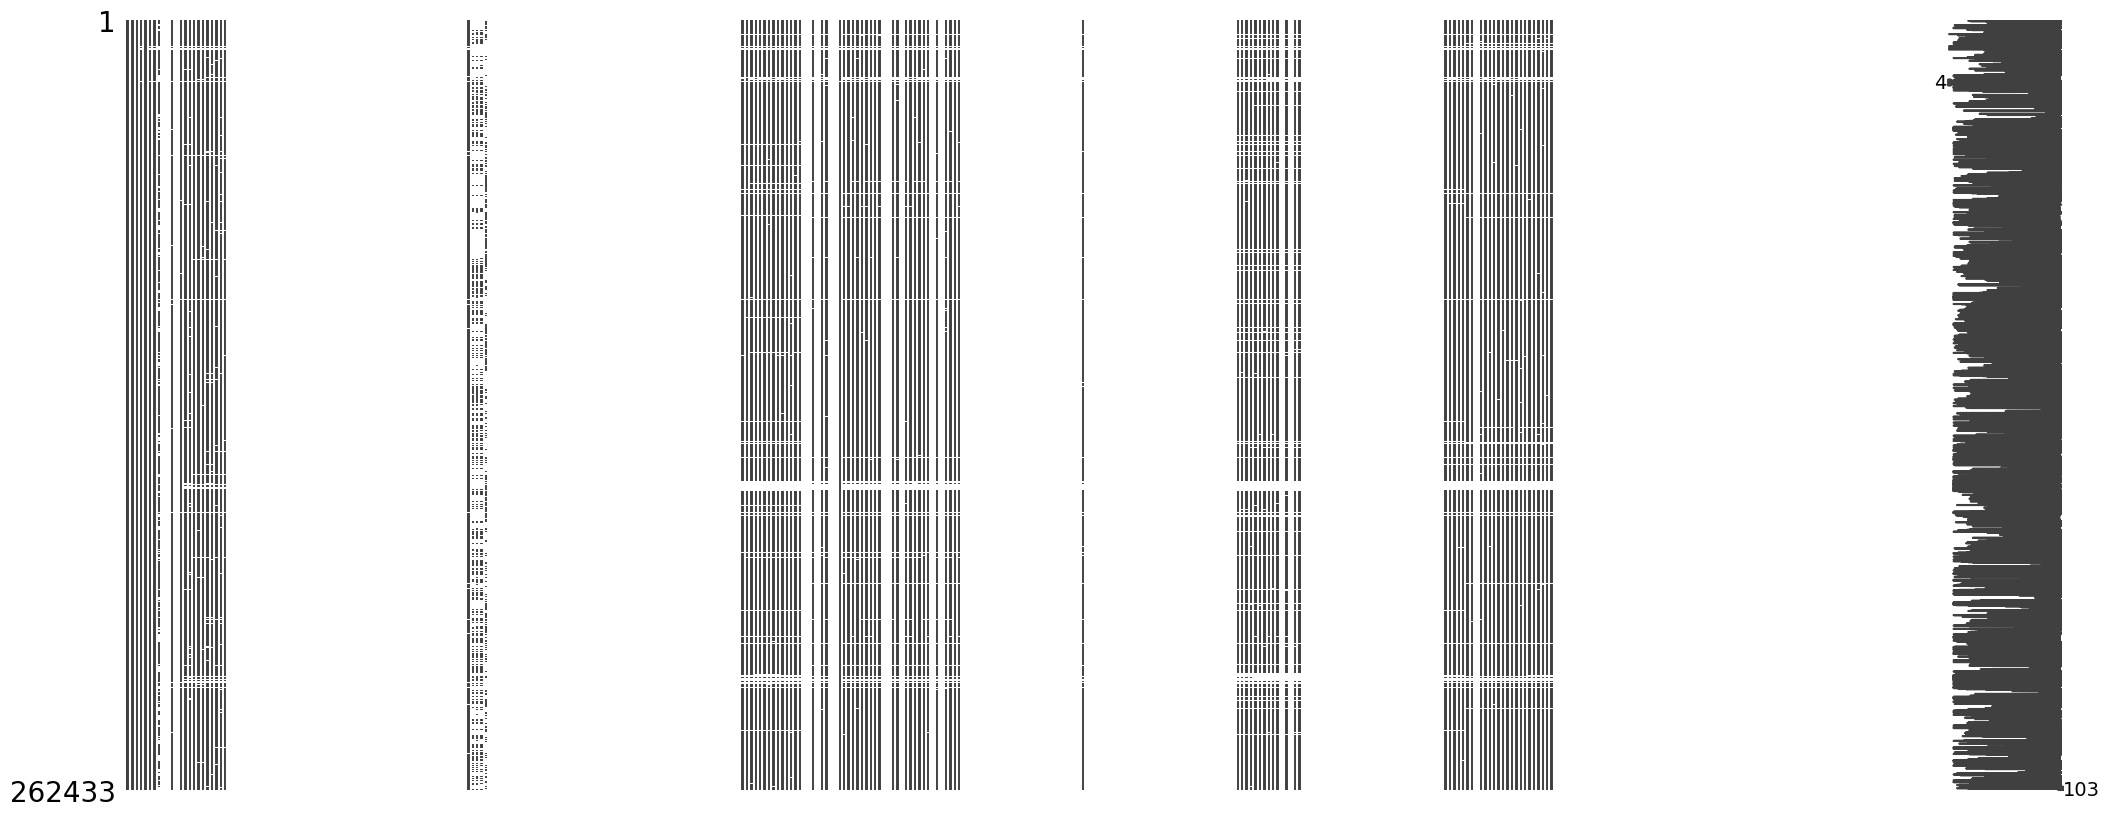

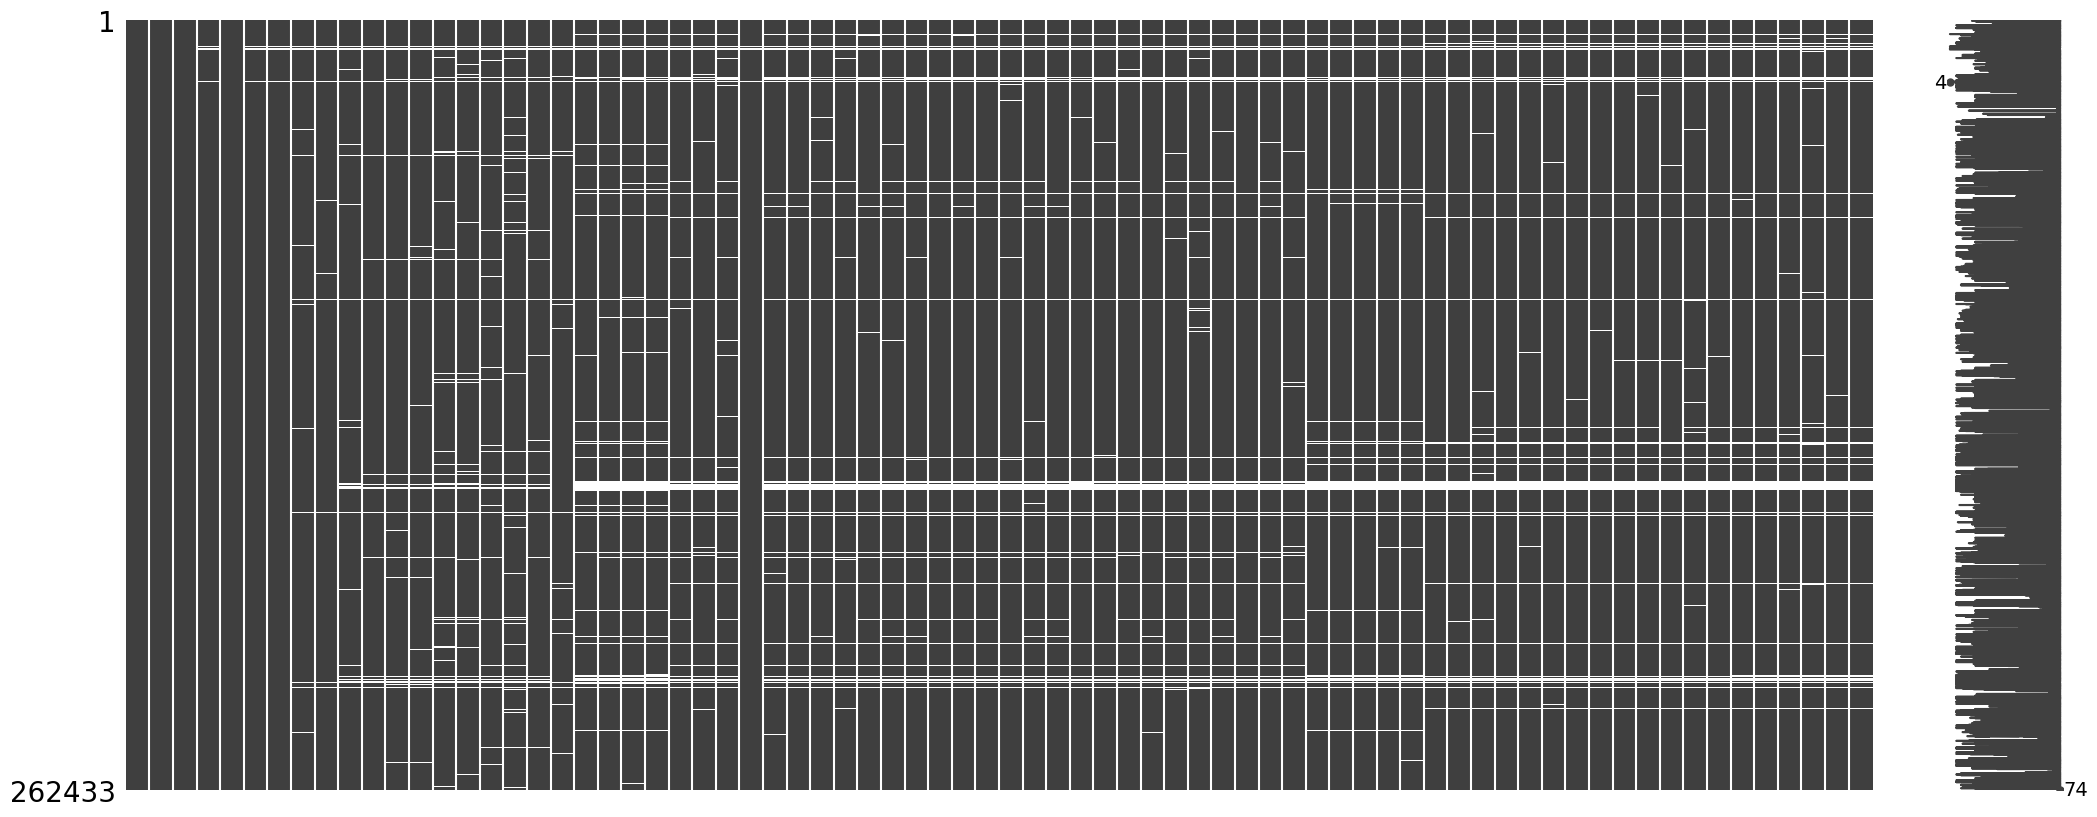

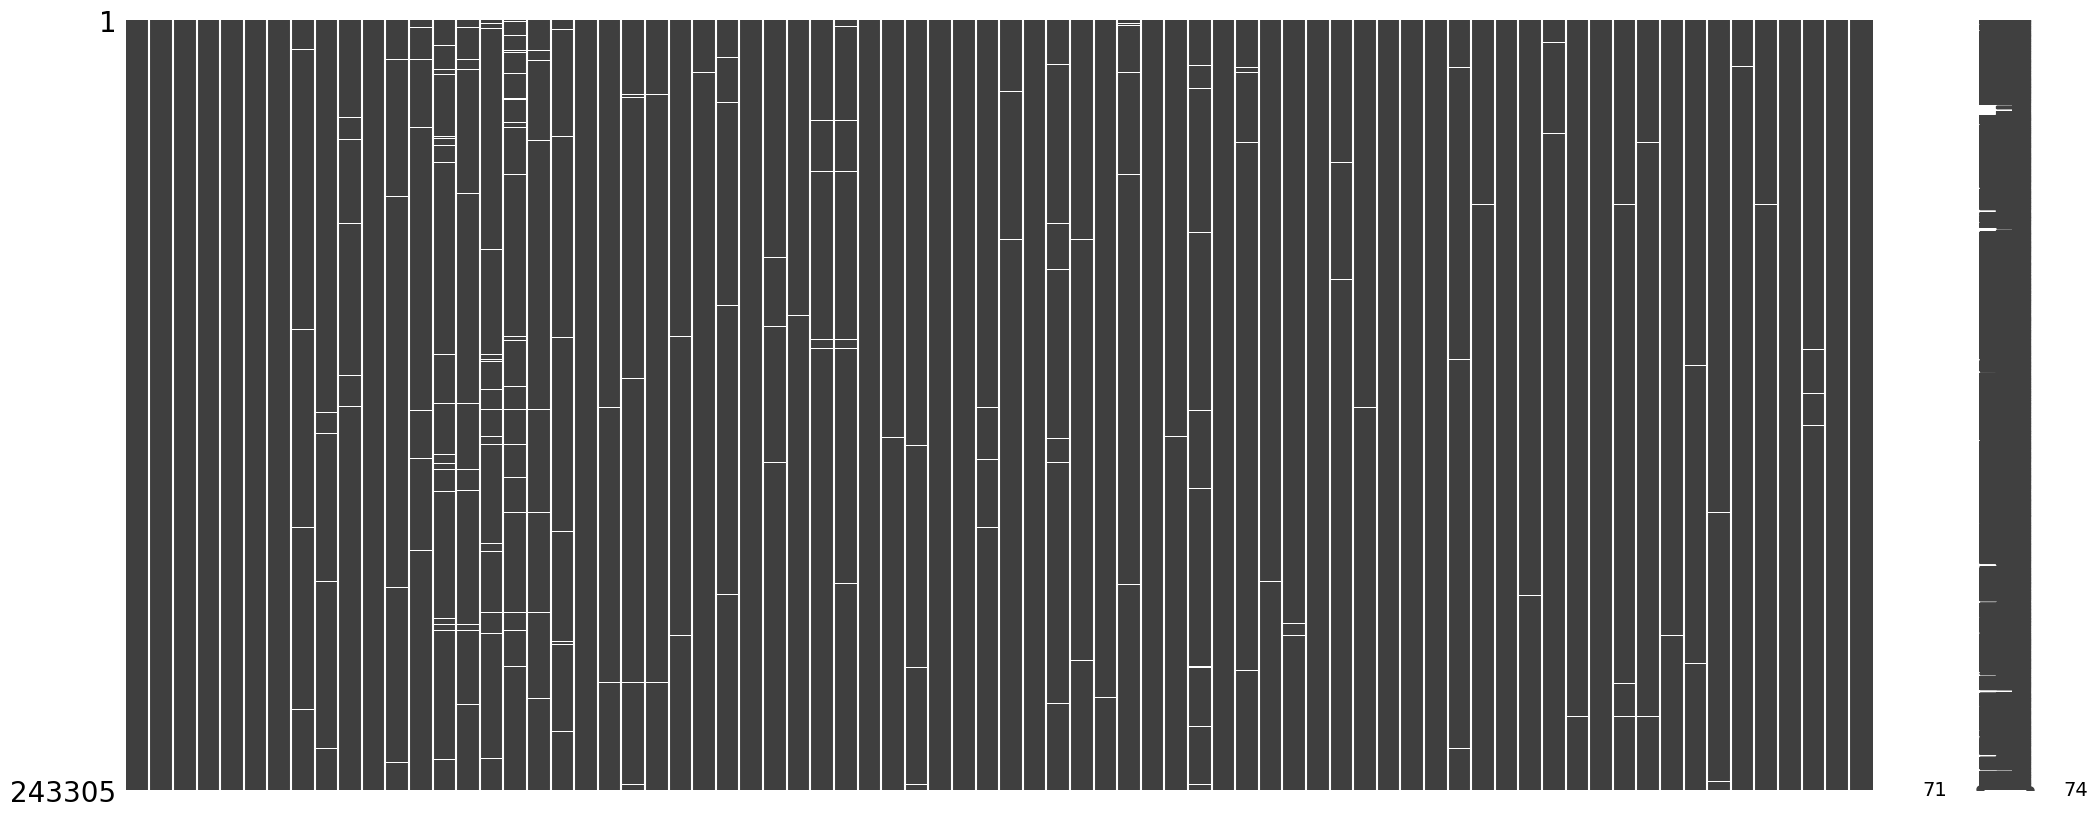

In [99]:
hs_df = clean_data(hs_df_raw)

In [97]:
hs_df_raw.fillna(value=np.nan, inplace=True)

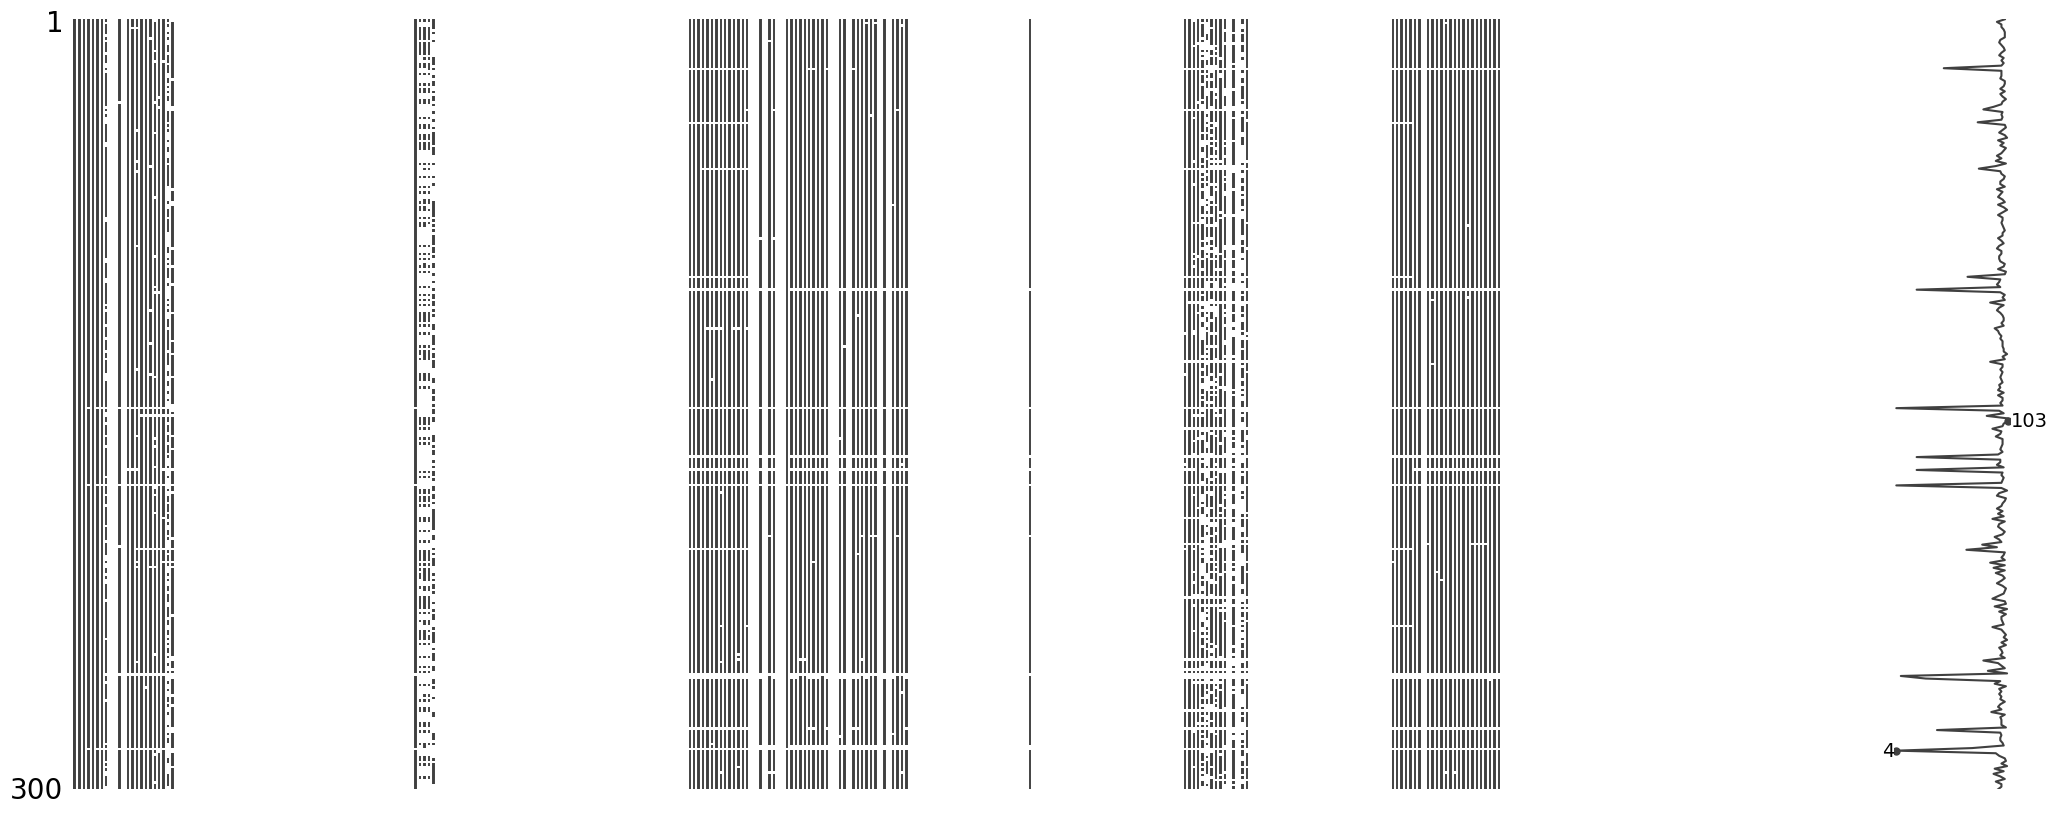

In [27]:
msno.matrix(hs_df_raw.sample(300))
plt.show();

As we can see here, we have a lot of missing data.
It's also worth noting that there seems to be some patterns to the missingness. 
For example it seems like people who are missing data in the first column of the middle chunk are more 
likely to have the proceeding columns also be missing. 

In [41]:
# Get columns that are only missing <= 5% of data
n_rows = hs_df_raw.shape[0]
non_empty_cols = []
for col in hs_df_raw.columns:
    if hs_df_raw[col].isna().sum() / n_rows < 0.05:
        non_empty_cols.append(col)

In [42]:
# Create new df with only non-empty values
hs_df_non_empty = hs_df_raw[non_empty_cols]

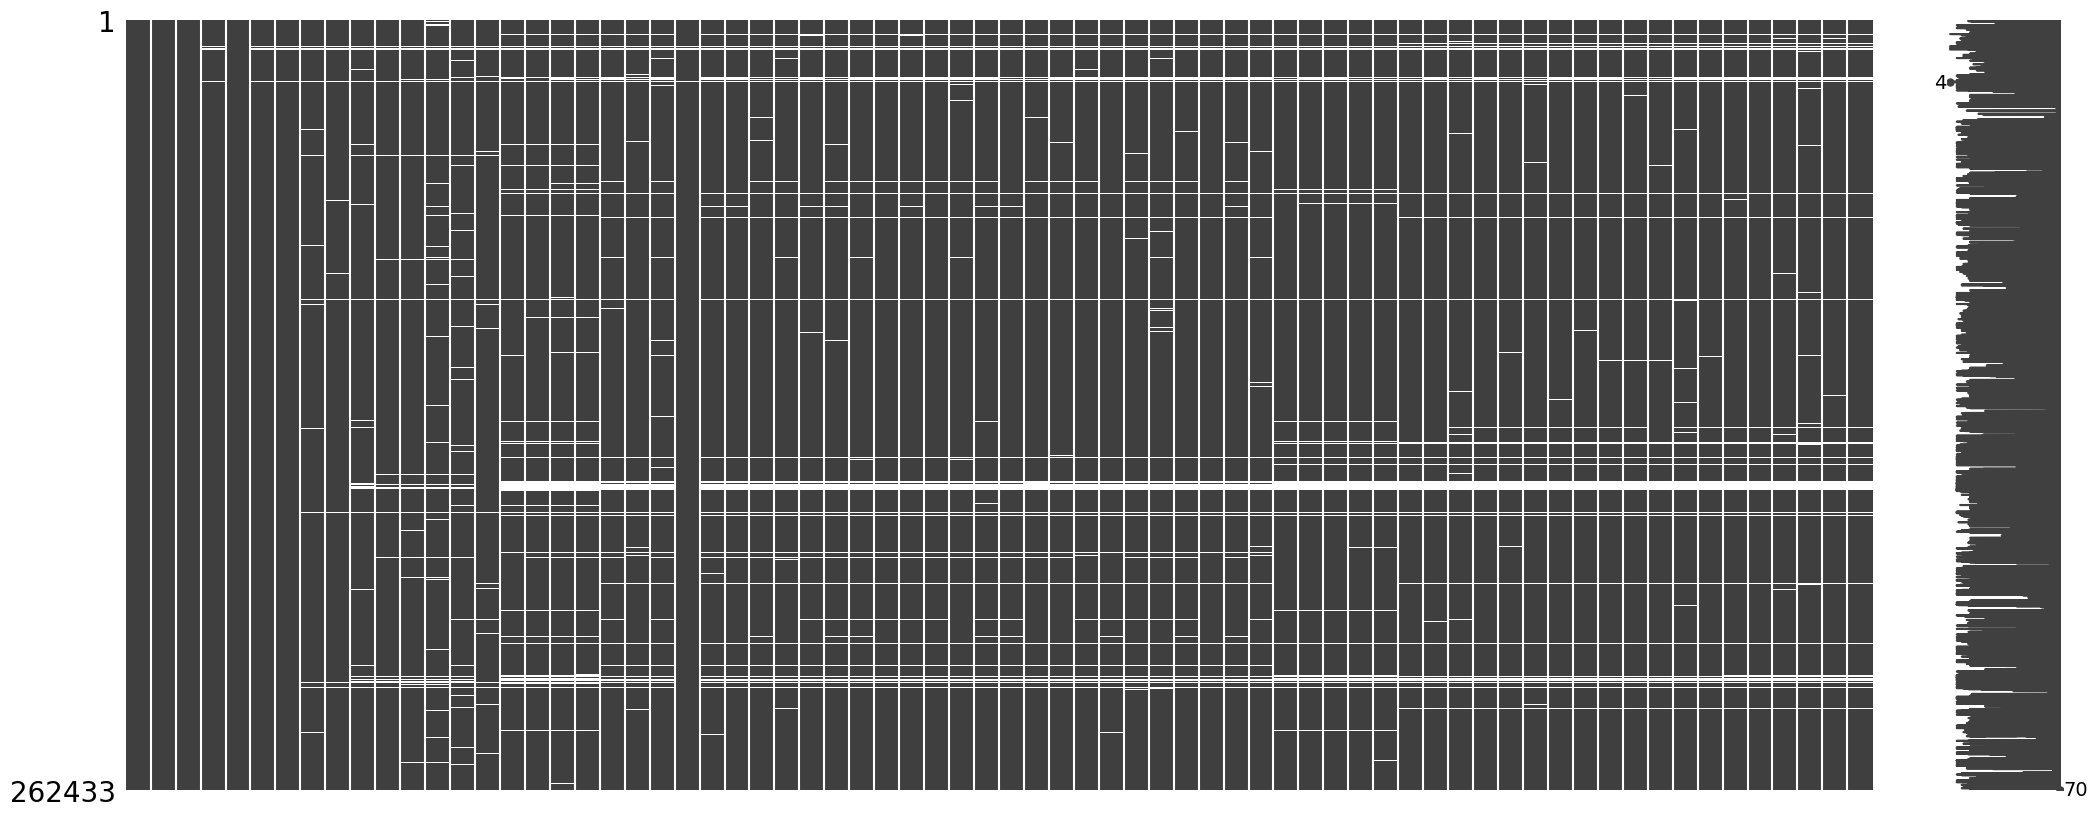

In [43]:
msno.matrix(hs_df_non_empty)
plt.show();

This looks much better, now all of our columns have data.
It looks like there are some rows that might be missing, what happens when we drop that data?

In [53]:
n_cols = hs_df_raw.shape[1]
non_empty_rows = []
for row in range(len(hs_df_non_empty)):
    if hs_df_non_empty.iloc[row, :].isna().sum() / n_cols < 0.05:
        non_empty_rows.append(row)

In [57]:
hs_df = hs_df_non_empty.iloc[non_empty_rows, :]

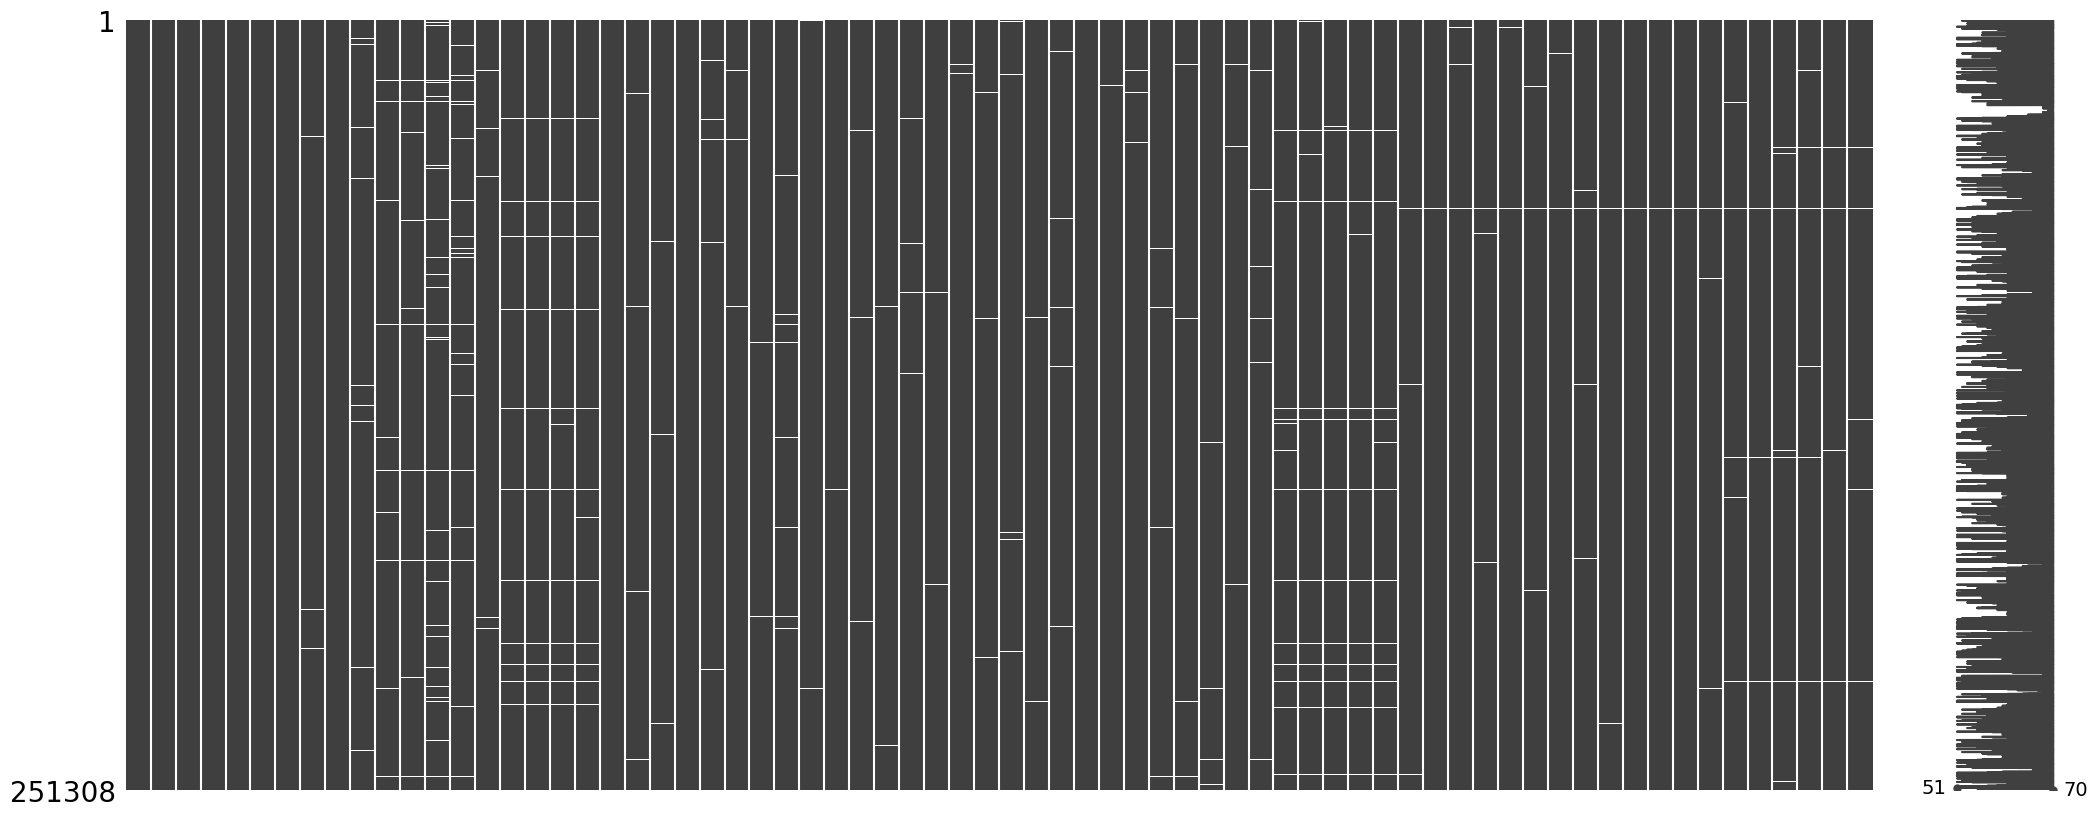

In [58]:
msno.matrix(hs_df)
plt.show();

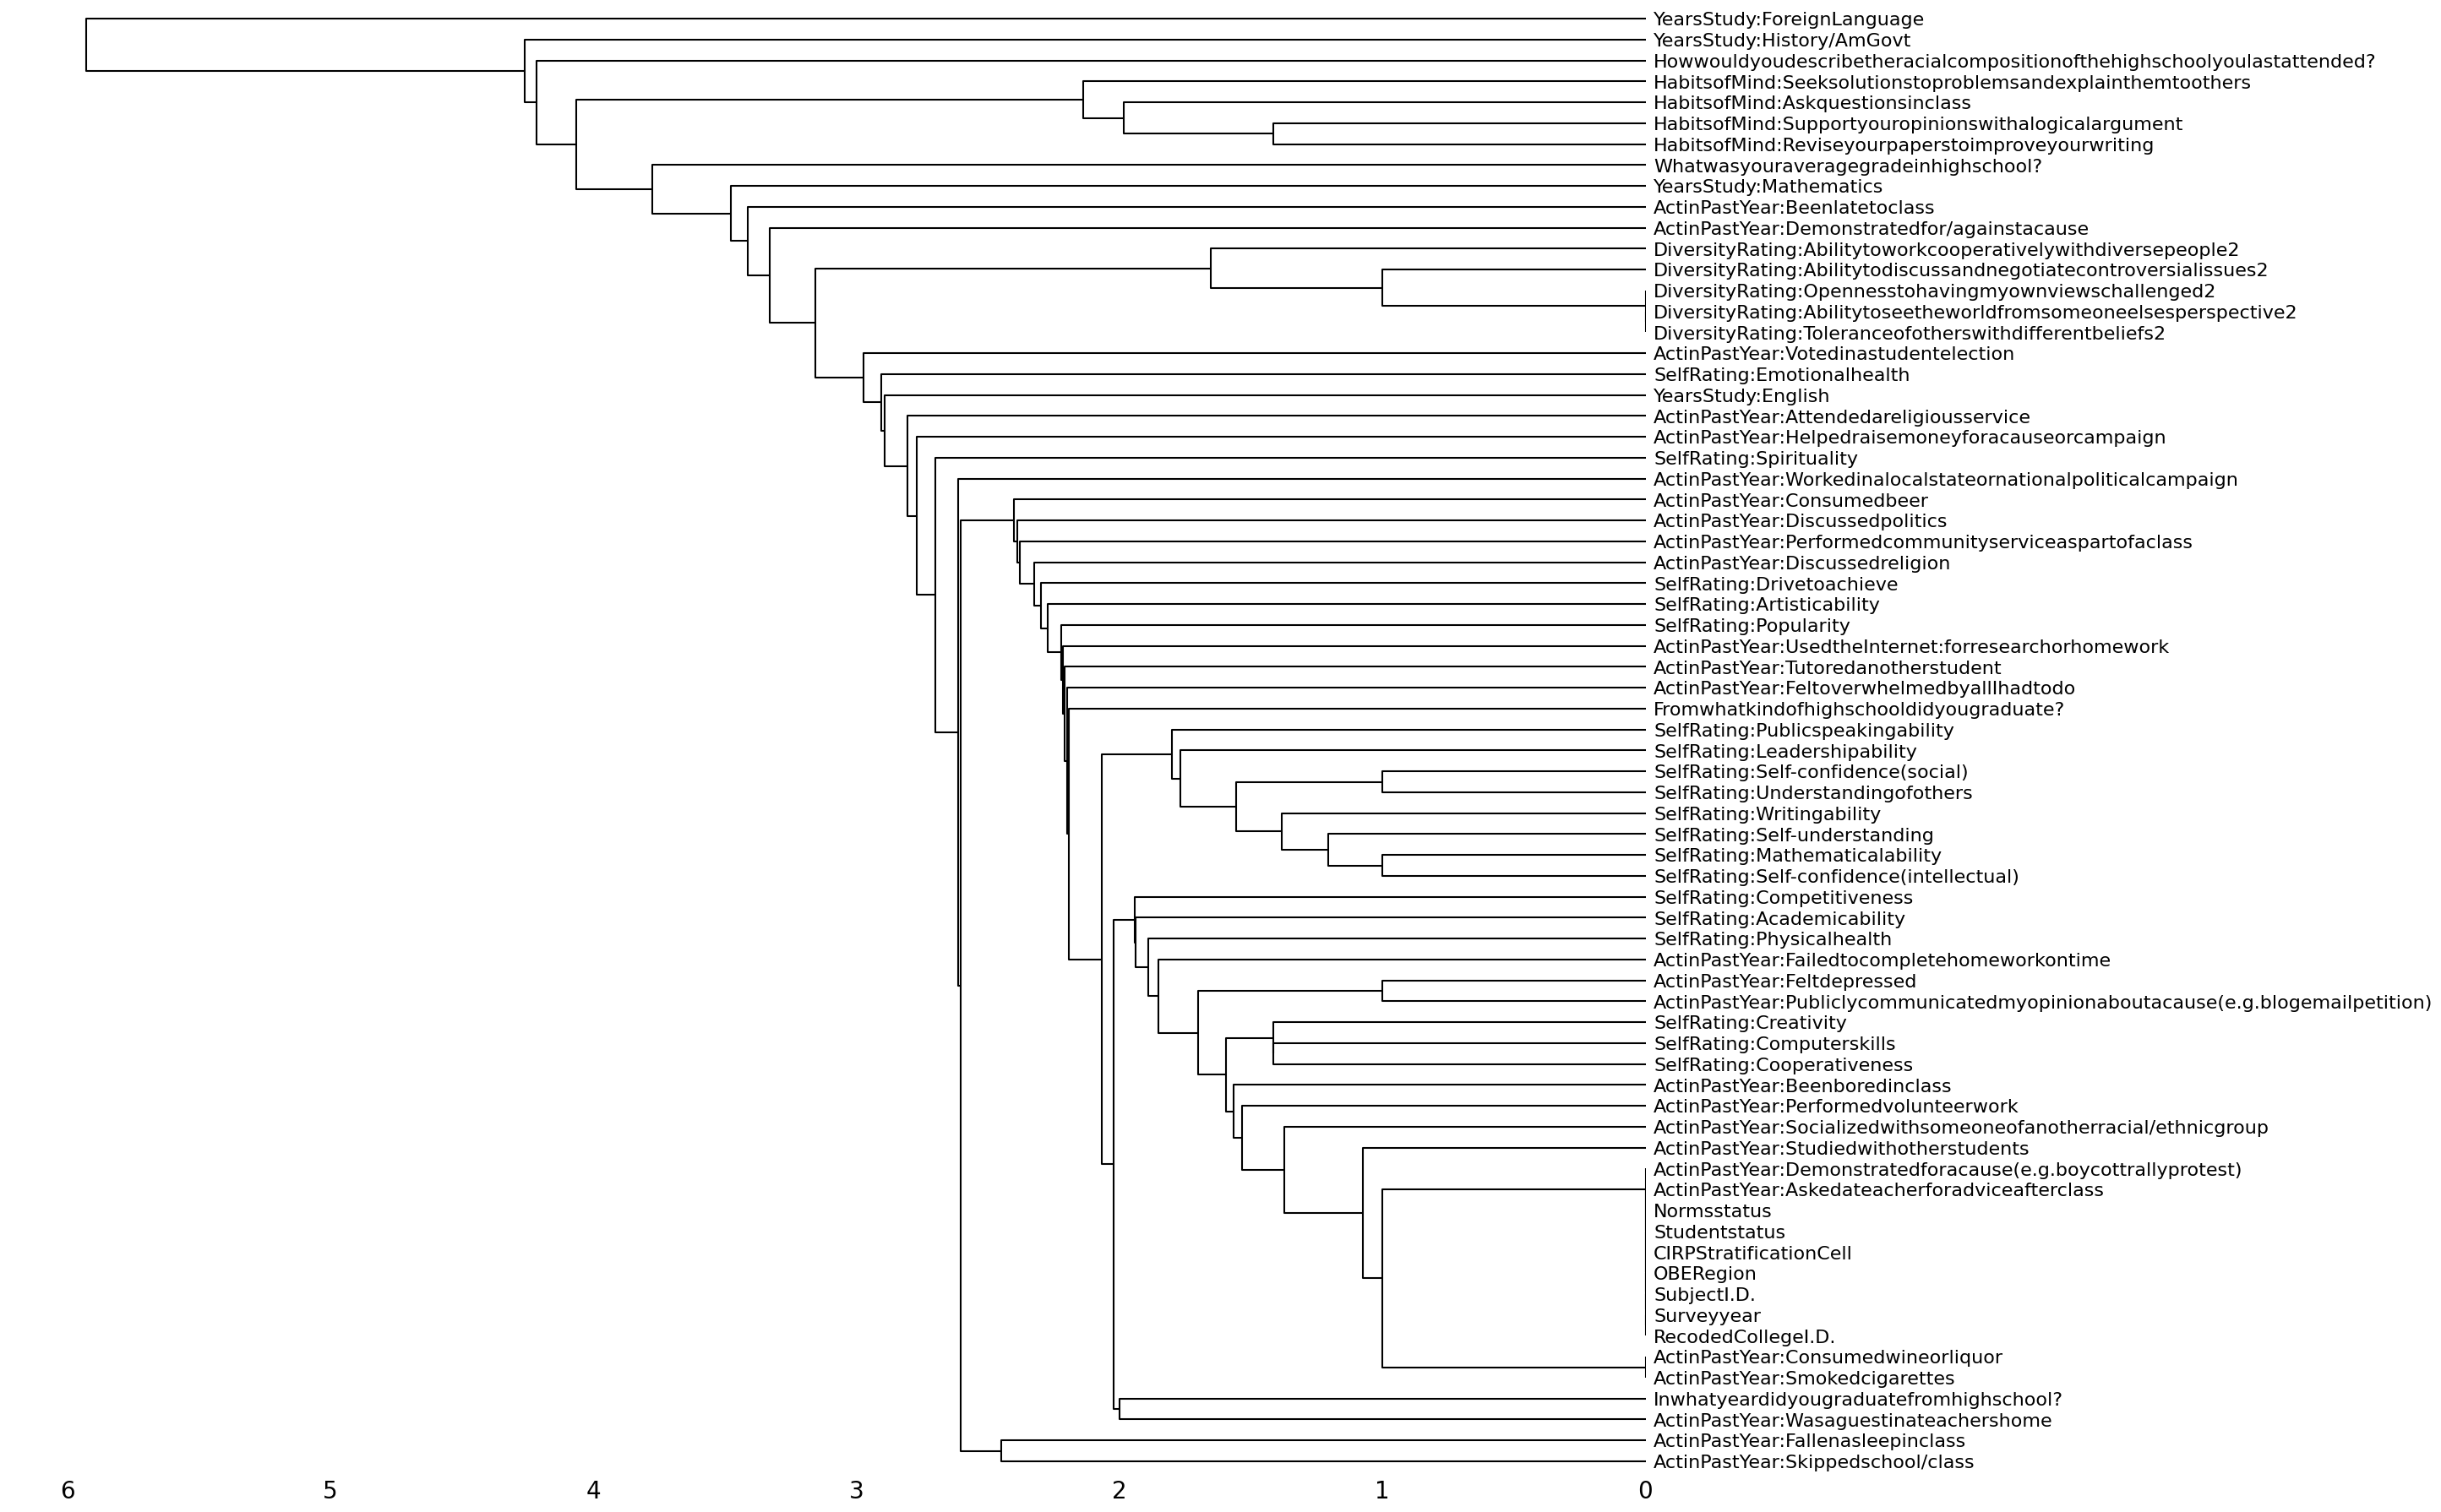

In [59]:
msno.dendrogram(hs_df.sample(1000))
plt.show();

"Leaves that are linked together fully predict one another's presence (i.e. one variable might always be empty when antoher is filled, or they might always both be filled or both empty, and so on)" [missingno documentation](https://github.com/ResidentMario/missingno).

It's interesting to note that While SATMath and SATVerbal are linked together, SATWriting is separated slightly.
Noteworthy since the writing component is not longer part of the SAT if I'm recalling correctly. 

In [109]:
# Save all the columns to a txt file
with open("../stats/HIGH_SCHOOL_features.txt", "w") as f:
    for feature in hs_df.columns:
        f.writelines(f"{feature}\n")

## Demographics

In [60]:
db_path = "../data/00-external/DEMOGRAPHICS.db"

In [61]:
query_2010 = """
SELECT * FROM DEMOGRAPHICS
WHERE Surveyyear == 2010;
"""

dem_df_raw = run_query(db_path, query_2010)

In [ ]:
dem_df = clean_data(dem_df_raw)

In [71]:
print(dem_df_raw.shape)
print(dem_df.shape)

(262433, 184)
(247628, 37)


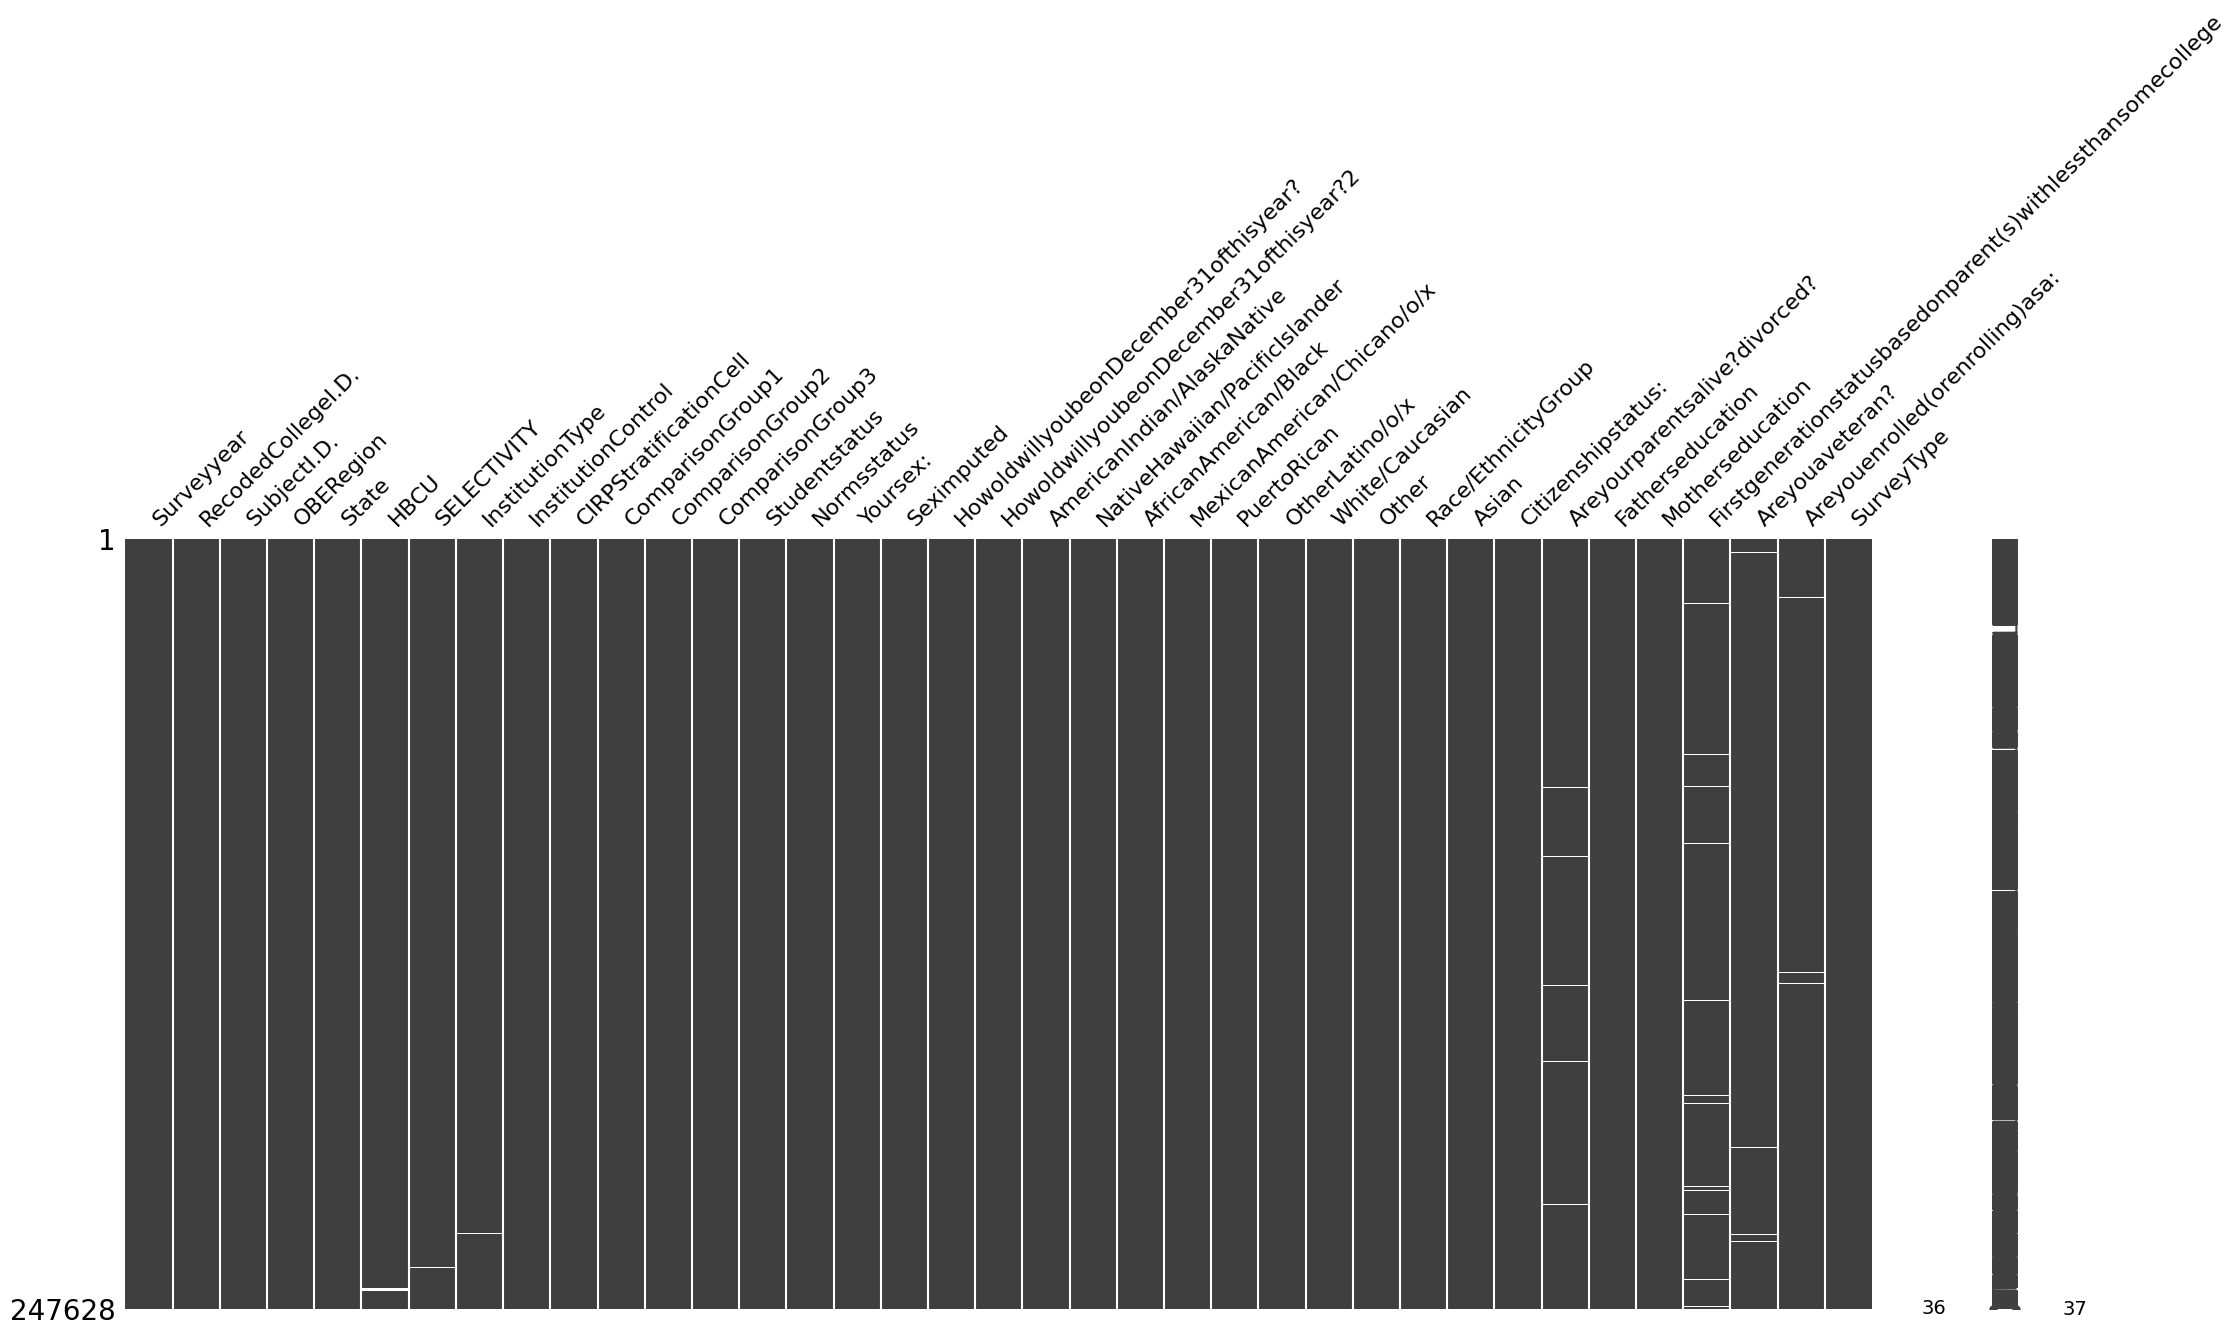

In [72]:
msno.matrix(dem_df)
plt.show();

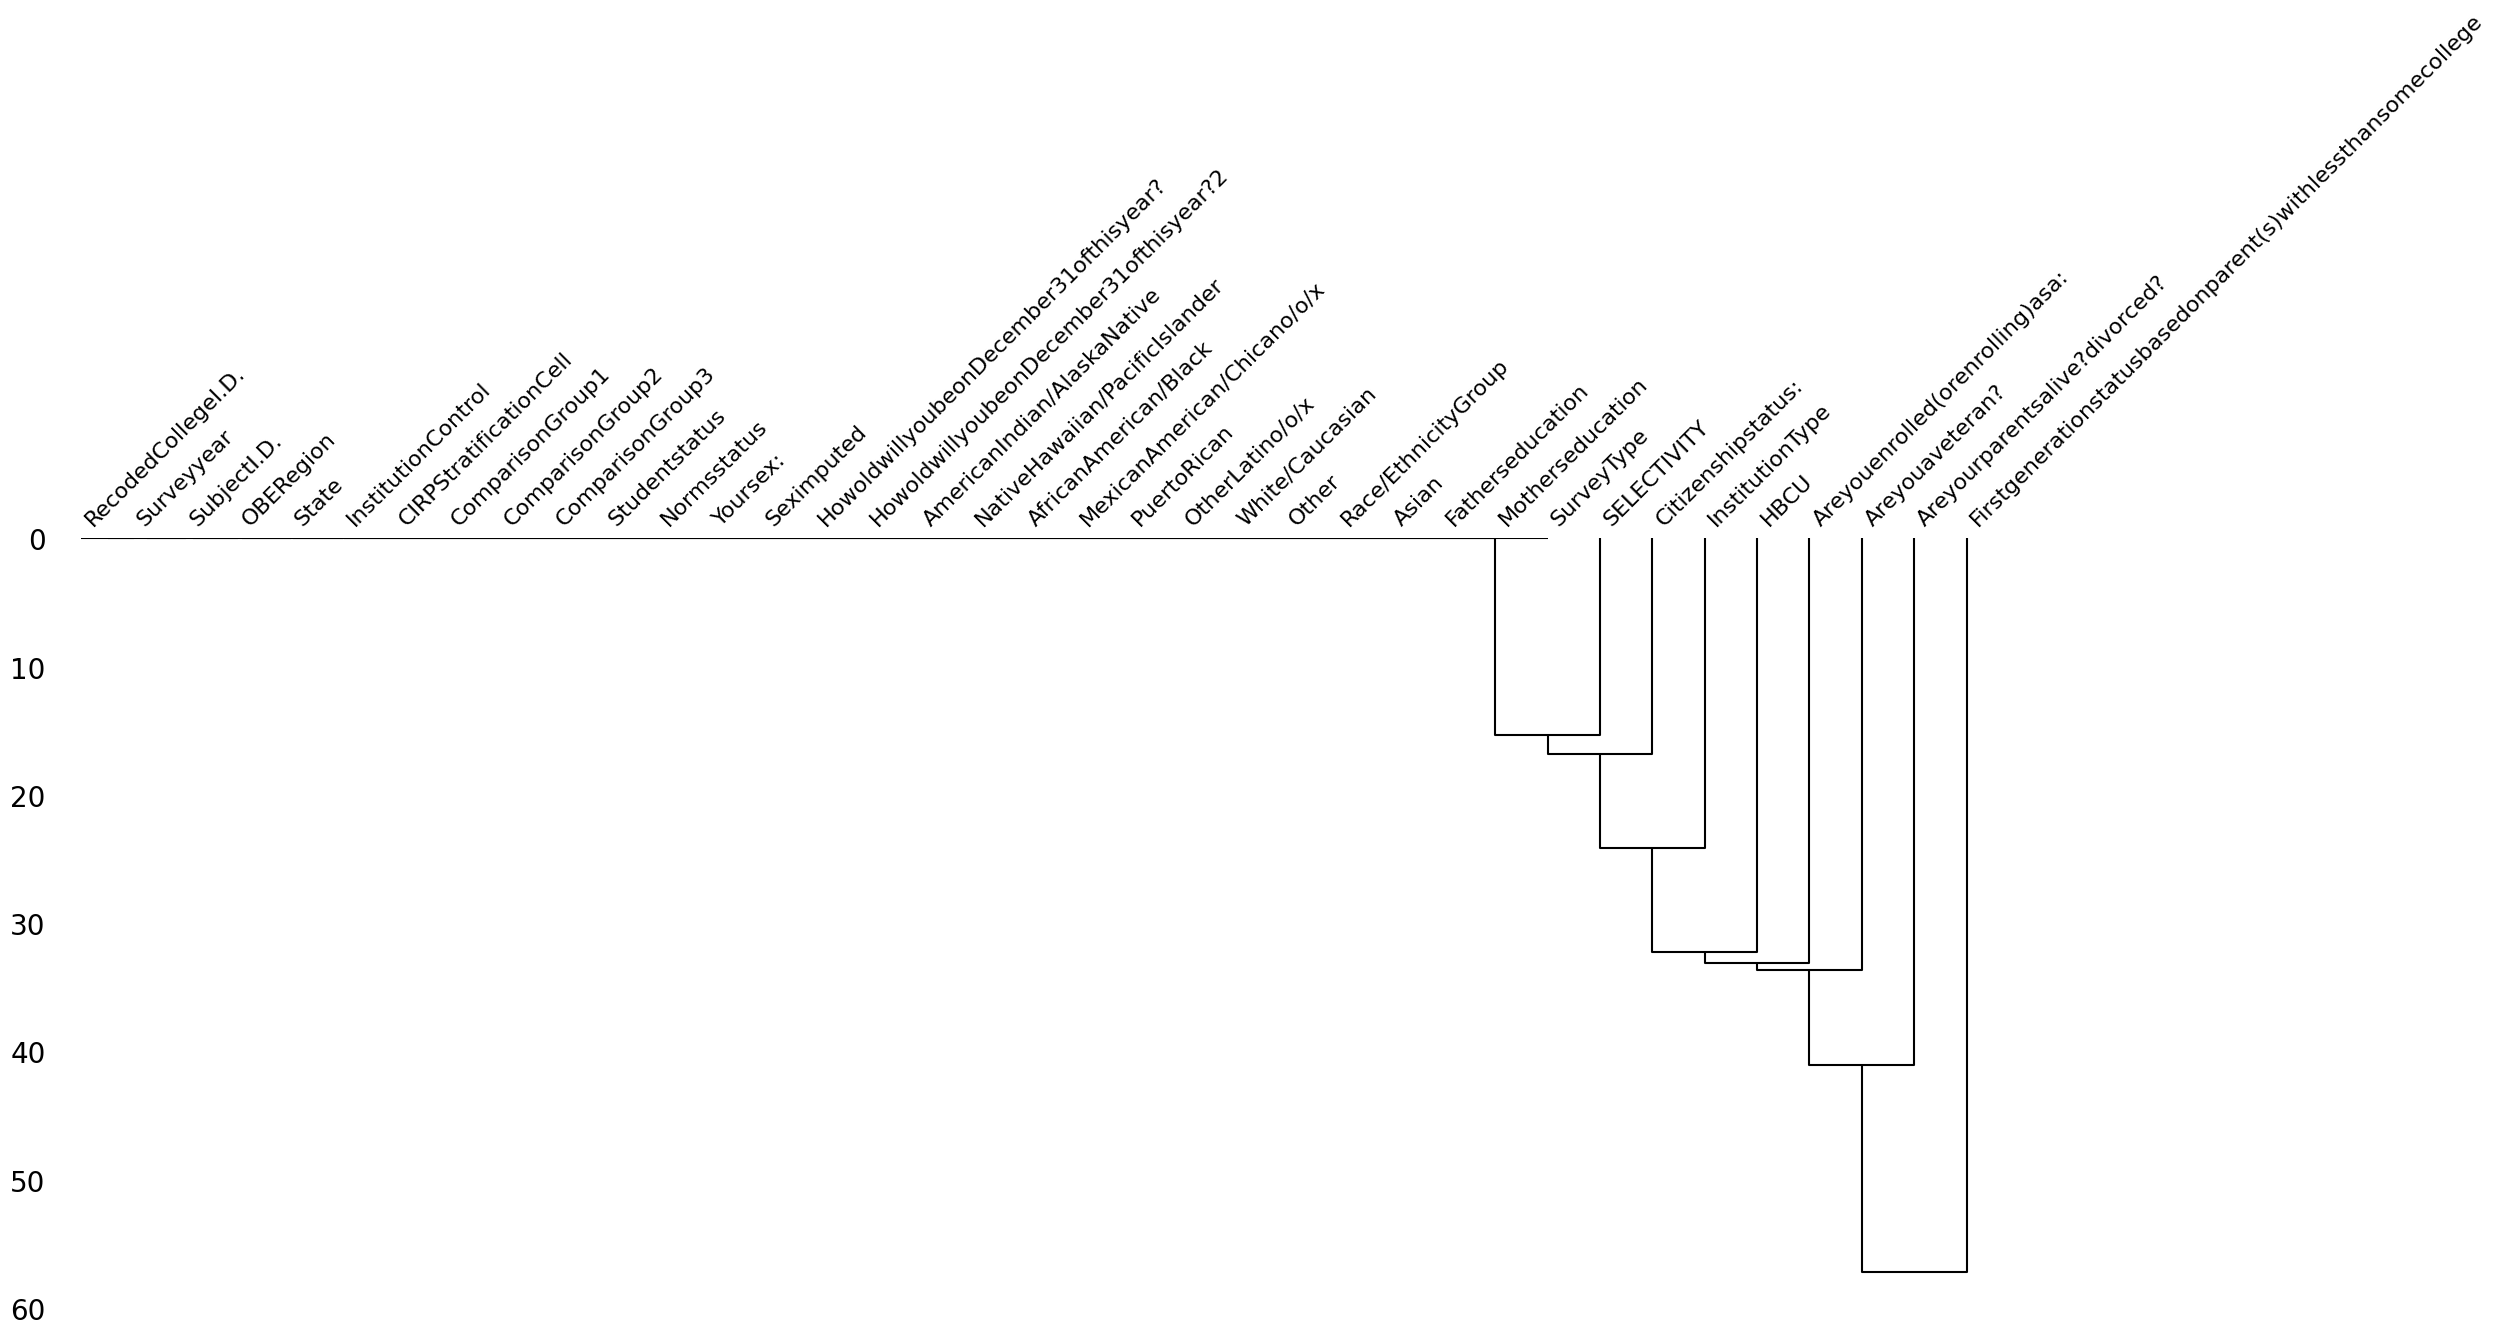

In [73]:
msno.dendrogram(dem_df)
plt.show();

In [110]:
# Save all the columns to a txt file
with open("../stats/DEMOGRAPHICS_features.txt", "w") as f:
    for feature in dem_df.columns:
        f.writelines(f"{feature}\n")

## TFS Choice

In [76]:
db_path = "../data/00-external/TFS_CHOICE_2008_2010.db"

In [77]:
with sqlite3.connect("../data/00-external/TFS_CHOICE_2008_2010.db") as conn:
    cursor = conn.cursor()
    cursor.execute("""
        SELECT name FROM sqlite_schema
        WHERE type='table'
        ORDER BY name;
    """)
    print(cursor.fetchall())

[('CHOICE',)]


In [79]:
query_2010 = """
SELECT * FROM CHOICE
WHERE Year == 2010;
"""

tfs_df_raw = run_query(db_path, query_2010)

In [80]:
tfs_df = clean_data(tfs_df_raw)

In [81]:
print(tfs_df_raw.shape)
print(tfs_df.shape)

(262433, 111)
(245548, 13)


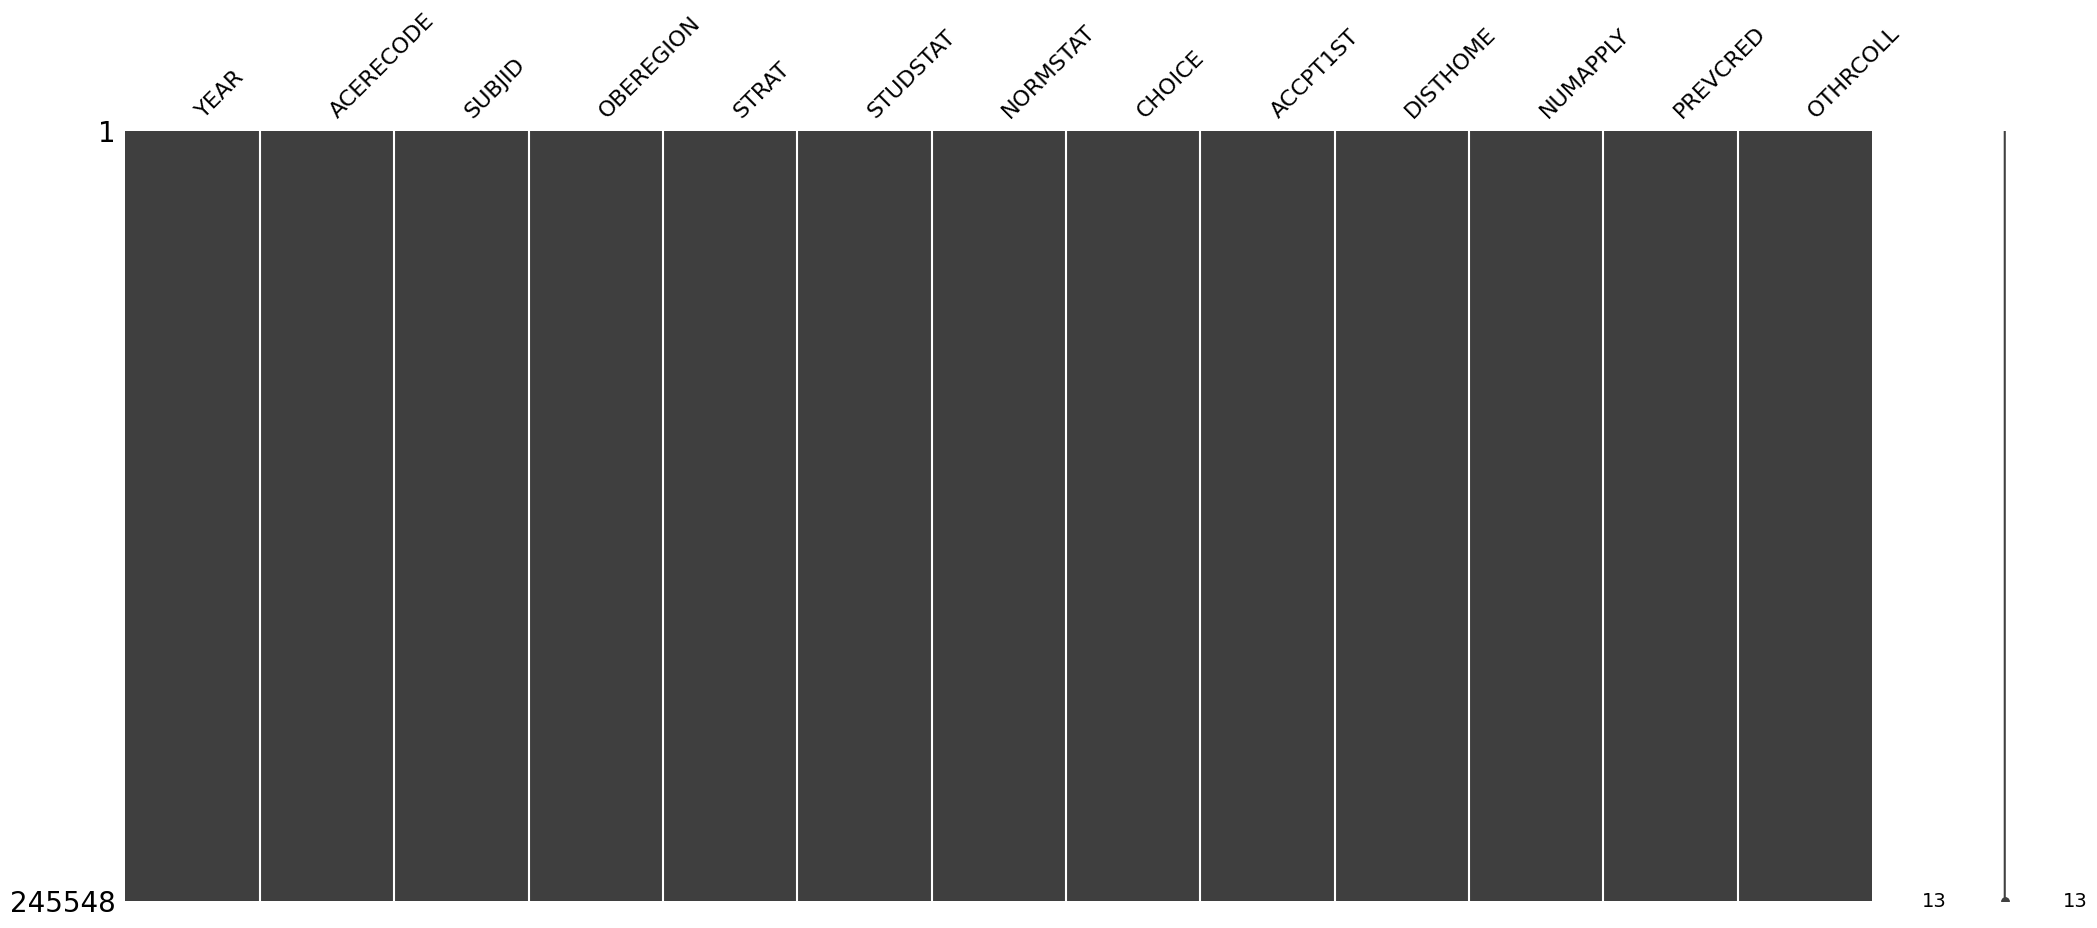

In [82]:
msno.matrix(tfs_df)
plt.show();

/home/mitch/.local/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2844: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([dvw, 0])


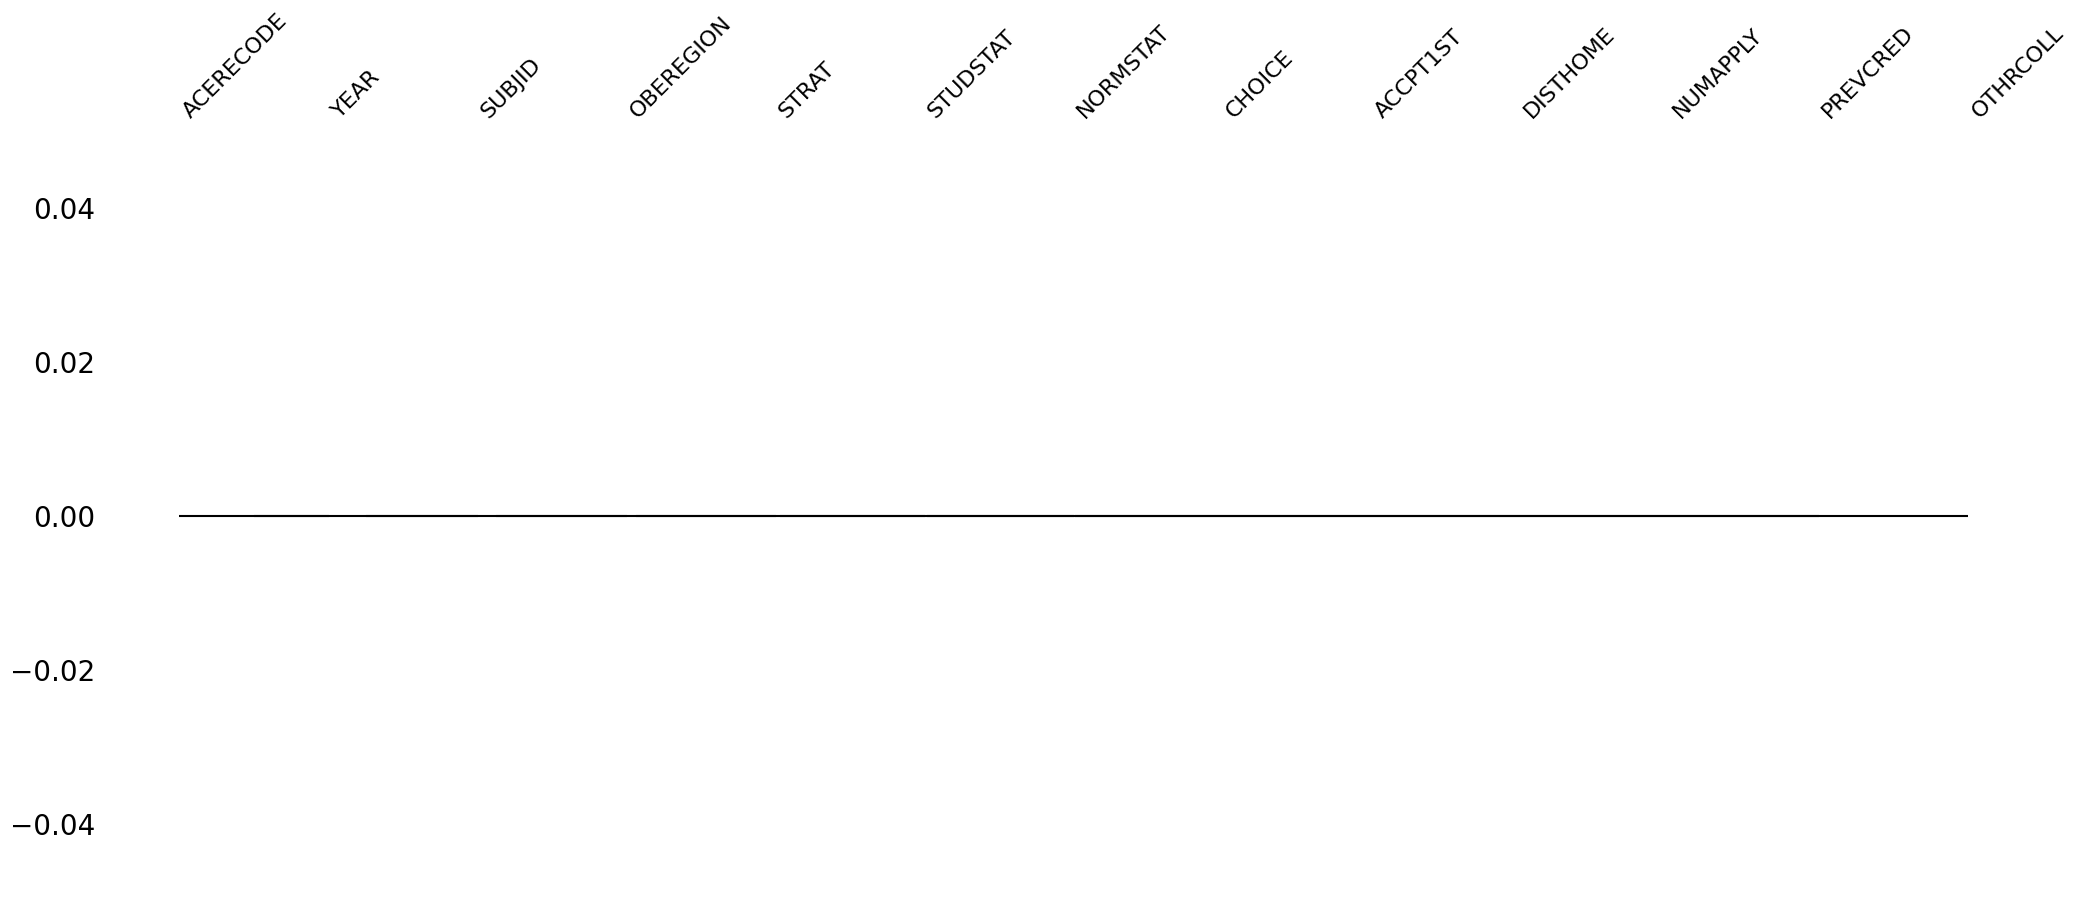

In [83]:
msno.dendrogram(tfs_df)
plt.show();

In [111]:
# Save all the columns to a txt file
with open("../stats/TFS_features.txt", "w") as f:
    for feature in tfs_df.columns:
        f.writelines(f"{feature}\n")